<a href="https://colab.research.google.com/github/SighanoCel/My-data-science-project/blob/main/project_2_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
df =pd.read_csv('/content/drive/MyDrive/DATA Pandas/mpg.csv')

In [65]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Regularization task to avoid overfitting of our polynomial regression model

In [66]:
X=df[['mpg','weight']]

In [67]:
y= df['acceleration']

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

Perform scaling or feature scaling to use a ridge regression model.

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaling_model= StandardScaler()

In [72]:
scaled_X_train= scaling_model.fit_transform(X_train)

scaled_X_test = scaling_model.transform(X_test)

In [76]:
scaled_X_train[:6]

array([[-1.24421016,  1.36754099],
       [ 0.17437776, -0.87009432],
       [ 0.93525674, -0.86769857],
       [ 0.17437776, -1.08810804],
       [-0.3672649 ,  0.1385186 ],
       [-0.08354731,  1.13275699]])

In [77]:
X_train[:6]

,mpg,weight
41,14.0,4096
31,25.0,2228
269,30.9,2230
32,25.0,2046
259,20.8,3070
298,23.0,3900


In [78]:
from sklearn.linear_model import Ridge

In [81]:
model_ridge= Ridge(alpha=1)   # set the basic Ridge model with Alpha =1 as the hyper paramter, train and check its score

In [82]:
model_ridge.fit(scaled_X_train,y_train)

Ridge(alpha=1)

In [83]:
ridge_predict = model_ridge.predict(scaled_X_test)

In [84]:
ridge_predict[0:6]

array([16.13298534, 14.98562469, 17.93038281, 13.41134493, 13.78566132,
       15.69007559])

In [85]:
y_test.head(6)

,acceleration
130,16.5
202,17.8
322,17.9
104,12.5
91,12.0
242,12.8


In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
RMSE = np.sqrt(mean_squared_error(y_test, ridge_predict))

RMSE

np.float64(2.359143628059999)

How can we be sure that the choice of the hyperparameter lambda (alpha) which multiplies the penalty term (either the absolute value of the coefficients or the square of the coefficients) is the right one? How can we be sure that alpha = 1 is the best choice of hyperparameter? Here we will use cross-validation to determine the best choice of alpha (lambda).

In [89]:
from sklearn.linear_model import RidgeCV

In [107]:
model_cv = RidgeCV(alphas = np.linspace(0.01,5,7),scoring='neg_mean_squared_error')

In [108]:
model_cv.fit(scaled_X_train, y_train)

RidgeCV(alphas=array([0.01      , 0.84166667, 1.67333333, 2.505     , 3.33666667,
       4.16833333, 5.        ]),
        scoring='neg_mean_squared_error')

In [109]:
model_cv.alpha_    # actually, 10 is the best score

np.float64(5.0)

In [114]:
predict_cv = model_cv.predict(scaled_X_test)

In [115]:
RMSE = np.sqrt (mean_squared_error(y_test, predict_cv))

RMSE

np.float64(2.3602642079237537)

In [116]:
model_cv.coef_

array([ 0.58446252, -0.55978009])

Now let us use a SHAP model to interpret the predictions made by the trained Ridge_cv model.
shap_values are calculated for the test set (X_test). These values represent how much each feature contributed to pushing the prediction higher or lower for each individual test sample.

In [ ]:
#!pip install shap==0.44.1
!pip install shap

In [ ]:

import shap

shap.initjs()

In [127]:
Xtrain_features= pd.DataFrame(scaled_X_train,columns=['mpg','weight'])

Xtest_features=pd.DataFrame(scaled_X_test,columns=['mpg','weight'])

Xtrain_features

# Turn the scaled X_train to a dataframe in order to provide name for the scaled value of the training set. this will help to fill the parameter
# feature_names of the SHAP explainer

,mpg,weight
0,-1.244210,1.367541
1,0.174378,-0.870094
2,0.935257,-0.867699
3,0.174378,-1.088108
4,-0.367265,0.138519
...,...,...
273,-1.244210,1.713728
274,2.547288,-0.741921
275,1.128701,-0.795826
276,-1.244210,0.784175


In [128]:
Xtest_features

,mpg,weight
0,0.303340,-0.602968
1,-0.792841,0.285858
2,2.959969,-1.011444
3,-1.502135,2.337822
4,-1.373173,1.808360
...,...,...
115,0.406510,-0.304696
116,0.690228,-1.215083
117,0.819190,-0.957539
118,0.174378,-0.879677


In [136]:
explainer=shap.Explainer(model_cv,scaled_X_train,feature_names=Xtrain_features.columns,model_output= 'probability')

shap_values= explainer(Xtest_features)

print('shap_values shape', shap_values.values.shape)

print('X_test shape', Xtest_features.shape)

shap_values shape (120, 2)
X_test shape (120, 2)


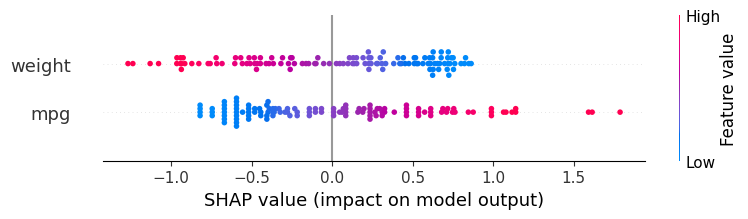

In [137]:
shap.summary_plot(shap_values.values[:, :],Xtest_features)

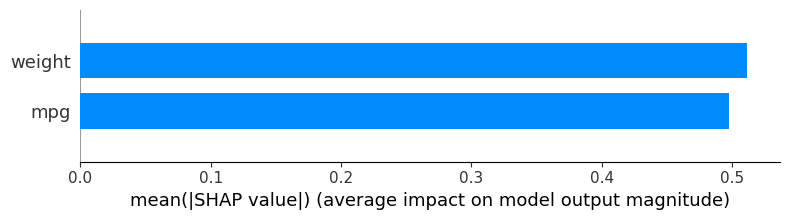

In [139]:
#SHAP feature importance bar chart,

shap.summary_plot(shap_values.values[:,:],Xtest_features,plot_type='bar')

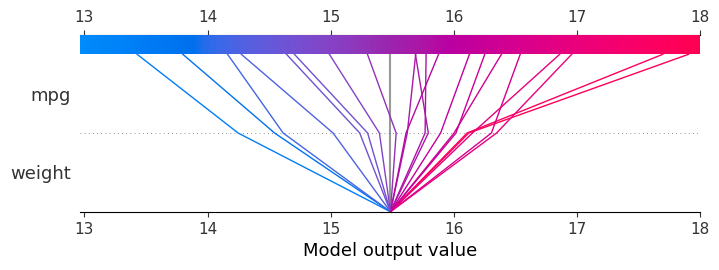

In [143]:
#SHAP Decision Plot
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values[:20, :], # select first 20 samples
    features=Xtest_features.iloc[:20], # Select the first 20 samples from X_test
    feature_names=Xtest_features.columns.tolist())

By this 3 plots, we can notice that the feature 'weight' is the one that impact the most our model prediction. It has a negative and the highest impact on a car capacity of accelaration.